# PyTorch Implementation of the paper 'Deep k-Nearest Neighbors'


This notebook contains a PyTorch implementation of the Deep k-Nearest Neighbors method introduced by Papernot & McDaniel (2018), which makes it possible to receive confidence scores for Deep Neural Network based predictions, that are more reliable than softmax scores. The paper can be found [here](https://arxiv.org/abs/1803.04765). The autors have also provided a basic implementation Tensorflow, which can be found [here](https://github.com/tensorflow/cleverhans/blob/master/cleverhans/model_zoo/deep_k_nearest_neighbors/dknn.py). However, this implementation is outdated. Hence, re-implemented the code here (in PyTorch).

First of all, a few package need to be installed. Besides Pytorch (pip packages torch and torchvision) we also need to install falconn and faiss. These two packages were used by Papernot and McDaniel to find the k-Nearest-Neighbors in high-dimensional spaces through local sensitive hashing (LSH). If you want to find our more about local sensitive hashing you can take a look [here](https://towardsdatascience.com/understanding-locality-sensitive-hashing-49f6d1f6134), [here](https://blog.mayflower.de/6498-lsh-nearest-neighbour-search.html), [here](https://www.youtube.com/watch?v=356GoYkmYKg&list=PLBv09BD7ez_6xoNh_luPdBmDCIHOQ3j7F) and [here](https://www.youtube.com/watch?v=gHdbqsDK9YY&list=PLBv09BD7ez_48heon5Az-TsyoXVYOJtDZ). However, I need to mention that falconn seems not to be under development anymore. Hence, someone might want to switch to another library providing local sensitive hashing in the future.

In [1]:
#! apt-get install libomp-dev
#
#! pip uninstall torch torchvision -y
#! pip install torch==1.4.0 torchvision==0.5.0
#! pip install falconn==1.3.1
#! pip install faiss==1.5.3

Next, let's load the required modules from the packages. Furthermore, for reproducibility reasons I also like to print out the package version that are used here and some GPU information if a GPU is available (since I only do the testing using MNIST a CPU should work here as well).

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torchvision
from torchvision import transforms
import matplotlib
import matplotlib.pyplot as plt
import pickle
import numpy as np
import falconn
import faiss
import platform
import enum
import copy
from bisect import bisect_left
import warnings
import time

print('python version:      {}'.format(platform.python_version()))
print('torch version:       {}'.format(torch.__version__))
print('torchvision version: {}'.format(torchvision.__version__))
print('numpy version:       {}'.format(np.__version__))
print('matplotlib version:  {}'.format(matplotlib.__version__))
print('pickle version:      {}'.format(pickle.format_version))

use_cuda = torch.cuda.is_available()
print('CUDA available:      {}'.format(use_cuda))
print('cuDNN enabled:       {}'.format(torch.backends.cudnn.enabled))
print('num gpus:            {}'.format(torch.cuda.device_count()))

if use_cuda:
    print('gpu:                 {}'.format(torch.cuda.get_device_name(0)))

python version:      3.6.9
torch version:       1.7.0
torchvision version: 0.8.1
numpy version:       1.19.5
matplotlib version:  3.2.2
pickle version:      4.0
CUDA available:      False
cuDNN enabled:       True
num gpus:            0


Put CUDNN to deterministic and set seed values for [reproducibility reasons](https://pytorch.org/docs/stable/notes/randomness.html).

In [3]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

random_seed = 0
torch.manual_seed(random_seed)
np.random.seed(random_seed)

Let's set some parameters for the Deep kNN.

In [4]:
num_epochs = 6            # number of training epochs
batch_size_train = 500    # batch size for training
batch_size_test = 1000    # batch size for testing
learning_rate = 0.001     # learning rate for training
calibset_size = 750       # size of the calibration set for DkNN
neighbors = 75            # number of nearest neighbors for DkNN
number_bits = 17          # number of bits for LSH for DkNN

log_interval = 10         # printing training statistics after 10 iterations

## Data

### Specify Dataset

Define data transform functions for training and test set.

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

Define training and test set.

In [6]:
# Training set
trainset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform
)

# Test set and calibration set
orig_testset = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transform
)
orig_testset_size = len(orig_testset)

testset_size = orig_testset_size - calibset_size
testset, calibset = torch.utils.data.random_split(orig_testset, [testset_size, calibset_size])

### Load Data

Create train, test and calibration data loader.

In [7]:
# Create training data loader
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size_train, shuffle=True, num_workers=2
)

# Create test data loader
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size_test, shuffle=False, num_workers=2
)

# Create calib data loader
calibloader = torch.utils.data.DataLoader(
    calibset, batch_size=calibset_size, shuffle=False, num_workers=2
)

Print out the sizes of the datasets.

In [8]:
print('trainset size: {}'.format(len(trainloader.dataset)))
print('testset size:  {}'.format(len(testloader.dataset)))
print('calibset size: {}'.format(len(calibloader.dataset)))

trainset size: 60000
testset size:  9250
calibset size: 750


### Display Samples

In [9]:
def show_samples(data, targets):
    data = data.numpy()
    print("tensor shape: " + str(data.shape))
    
    fig = plt.figure()
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.tight_layout()
        
        img = data * 0.3081 + 0.1307  # unnormalize
        plt.imshow(img[i][0], cmap='gray', interpolation='none')
        plt.title("Ground Truth: {}".format(targets[i]))
        
        plt.xticks([])
        plt.yticks([])

Load a few test images and display them.

tensor shape: (1000, 1, 28, 28)


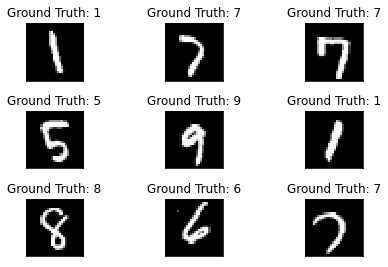

In [10]:
dataiter = enumerate(testloader)
_, (sample_data, sample_targets) = next(dataiter)

show_samples(sample_data, sample_targets)

## Define Training and Test Functions

Let's define the functions for training and testing.

In [11]:
def train(num_epochs, model, optim, crit, train_loader, test_loader):
    train_losses = []
    test_losses = []
    test_accs = []
    
    for epoch in range(1, num_epochs + 1):
        model, train_losses = train_one_epoch(epoch, model, optim, crit, train_loader, train_losses)
        test_losses, test_accs = test(model, crit, test_loader, test_losses, test_accs)
        
    print('Finished Training')
    return train_losses, test_losses, test_accs
    

def train_one_epoch(epoch_num, model, optim, crit, data_loader, losses):
    model.train()
    running_loss = 0.0
    
    for batch_idx, data in enumerate(data_loader):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, targets = data

        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        
        # Zero the parameter gradients
        optim.zero_grad()
        
        # Forward + backward + optimize
        outputs = model(inputs)
        loss = crit(outputs, targets)
        loss.backward()
        optimizer.step()
        
        # Print statistics
        running_loss += loss.item()
        
        if batch_idx % log_interval == 0:
            dataset_size = len(data_loader.dataset)
            used_samples = batch_idx * len(inputs)
            train_progress = 100. * batch_idx / len(data_loader)
            avg_batch_loss = running_loss / log_interval
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch_num, used_samples, dataset_size, train_progress, avg_batch_loss
            ))
            
            losses.append(avg_batch_loss)
            running_loss = 0.0
            
    return model, losses
     
    
def test(model, crit, data_loader, test_losses, test_accs):
    model.eval()
    correct = 0
    test_loss = 0
    
    with torch.no_grad():
        for data in data_loader:
            # Get the inputs; data is a list of [inputs, labels]
            inputs, targets = data

            if use_cuda:
              inputs, targets = inputs.cuda(), targets.cuda()
            
            # Forward + loss + correct
            outputs = model(inputs)
            test_loss += crit(outputs, targets).item()
            
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == targets).sum().item()
          
    dataset_size = len(data_loader.dataset)
    test_loss /= dataset_size
    acc = 100. * correct / dataset_size
    
    test_losses.append(test_loss)
    test_accs.append(acc)
    
    print('\nTest set: Avg. loss: {:.6f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, dataset_size, acc
    ))
    
    return test_losses, test_accs

## Network Architecture

Let's define the neural network based model architecture for MNIST, that has also been [used by Papernot and McDaniel](https://github.com/tensorflow/cleverhans/blob/master/cleverhans/model_zoo/deep_k_nearest_neighbors/dknn.py).

In [12]:
class MnistNet(nn.Module):
    def __init__(self):
        super(MnistNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=8, stride=2, padding=3)
        self.relu1 = nn.ReLU(True)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=6, stride=2)
        self.relu2 = nn.ReLU(True)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=5)
        self.relu3 = nn.ReLU(True)
        self.fc = nn.Linear(128, 10)

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.relu3(self.conv3(x))
        x = x.view(-1, 128)
        x = self.fc(x)
        return x

## Load Model

Let's train the model.

In [13]:
# Create Model
model = MnistNet()
criterion = nn.CrossEntropyLoss()

# Load Model
model.load_state_dict(torch.load("/Users/lehmann/research/laca/models/mnist_model.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

Put model in evaluation mode.

In [14]:
model.eval()

if use_cuda:
    model.cuda()
    print('Using ', torch.cuda.device_count(), ' GPU(s)')

Let's test our model again to see again which accuracy we have finally reached.

In [15]:
def test_final(model, data_loader):
    _, accs = test(model, criterion, data_loader, [], [])
    return accs[0]

In [16]:
test_acc = test_final(model, testloader); test_acc


Test set: Avg. loss: 0.000038, Accuracy: 9162/9250 (99.05%)



99.04864864864865

## Get Activations

Now, let's try to get the activations of each layer when feeding the trained model with images. To see again which layers we have let's print the model architecture.

In [17]:
model

MnistNet(
  (conv1): Conv2d(1, 64, kernel_size=(8, 8), stride=(2, 2), padding=(3, 3))
  (relu1): ReLU(inplace=True)
  (conv2): Conv2d(64, 128, kernel_size=(6, 6), stride=(2, 2))
  (relu2): ReLU(inplace=True)
  (conv3): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
  (relu3): ReLU(inplace=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)

Specify layers to be used for the DkNN.

In [18]:
layers = {
    'relu1': model.relu1,
    'relu2': model.relu2,
    'relu3': model.relu3,
    'fc': model.fc
}

Define function to get activations.

In [19]:
def get_activations(dataloader, model, layers):
    activations = {}
    activations['activations'] = {}
    activations['targets'] = None

    for layer_name in layers:
        print('## Fetching Activations from Layer {}'.format(layer_name))

        # Get activations for the data
        layer = layers[layer_name]
        activations['activations'][layer_name], targets = get_activations_from_layer(dataloader, model, layer)

        # Get the targets of that data
        if targets is not None:
            if activations['targets'] is not None:
                np.testing.assert_array_equal(activations['targets'], targets)
            else:
                activations['targets'] = targets

        print()

    return activations

def get_activations_from_layer(dataloader, model, layer):
    activations = []
    targets = []

    # Define hook for fetching the activations
    def hook(module, input, output):
        layer_activations = output.squeeze().detach().cpu().numpy()

        if len(layer_activations.shape) == 4:
            layer_activations = layer_activations.reshape(layer_activations.shape[0], -1)
        
        activations.append(layer_activations)

    handle = layer.register_forward_hook(hook)

    # Fetch activations
    for i, batch in enumerate(dataloader):
        print('Processing Batch {}'.format(i))

        if use_cuda:
            batch = batch.cuda()

        _ = model(batch[0])

        if len(batch) > 1:
          targets.append(batch[1].detach().cpu().numpy())

    print("done!")

    # Remove hook
    handle.remove()

    # Return activations and targets
    activations = np.concatenate(activations)

    if targets:
        targets = np.hstack(targets)
    else:
        None

    return activations, targets

Test activation fetching.

In [20]:
acts = get_activations(calibloader, model, layers)

## Fetching Activations from Layer relu1
Processing Batch 0
done!

## Fetching Activations from Layer relu2
Processing Batch 0
done!

## Fetching Activations from Layer relu3
Processing Batch 0
done!

## Fetching Activations from Layer fc
Processing Batch 0
done!



In [21]:
print('targets: {}'.format(acts['targets'].shape))
print()

for layer in layers:
    print('## layer {}'.format(layer))
    print('activations: {}'.format(acts['activations'][layer].shape))
    print()

targets: (750,)

## layer relu1
activations: (750, 12544)

## layer relu2
activations: (750, 3200)

## layer relu3
activations: (750, 128)

## layer fc
activations: (750, 10)



## Create Adversarials

Let's define a function to create adversarials. Later we want to test the DkNN with our normal test set and an adversarial version of the test set. The adversarial method that was used in the [code](https://github.com/tensorflow/cleverhans/blob/master/cleverhans/model_zoo/deep_k_nearest_neighbors/dknn.py) by Papernot and McDaniel is the Fast Gradient Sign method (FGSM) introduced by Goodfellow et al. (you can find the paper [here](https://arxiv.org/abs/1412.6572)). My implementation of FGSM is based on a [official PyTorch FSGM tutorial](https://pytorch.org/tutorials/beginner/fgsm_tutorial.html).

In [22]:
class CustomTensorDataset(Dataset):
    """
    TensorDataset with support for transforms
    """
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)


def fgsm_attack(image, epsilon, data_grad, normalized=True):
    # If image is normalized, denormalize with MNIST statistics
    if normalized:
        image = image * 0.3081 + 0.1307   # MNIST statistics

    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad

    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # If image should be normalized, normalize with MNIST statistics
    if normalized:
        perturbed_image = (perturbed_image - 0.1307) / 0.3081  

    # Return the perturbed image
    return perturbed_image


def create_adversarials(model, dataloader, epsilon):
    adv_examples = []
    targets = []
    init_preds = []
    final_preds = []

    # Loop over all examples in data set
    for data, target in dataloader:

        # If we run on GPU, send data and target to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # Calculate the loss
        loss = criterion(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # Save adversarial examples
        adv_ex = perturbed_data.detach().cpu().numpy()
        adv_examples.append(adv_ex)
        targets.append(target.item())
        init_preds.append(init_pred.item())
        final_preds.append(final_pred.item())

    # Return the accuracy and an adversarial example
    result = {
        'adv_examples': np.vstack(adv_examples),
        'targets': targets,
        'init_preds': np.array(init_preds),
        'final_preds': np.array(final_preds)
    }
    return result

Create adversarials for the testset using different values for epsilon.

In [23]:
epsilons = [0, .05, .1, .15, .2, .25, .3]

accuracies = []
adversarials = {}

# Create test data loader for adversarial creation (batch size needs to be 1)
testloader_adv = torch.utils.data.DataLoader(
    testset, batch_size=1, shuffle=False, num_workers=2
)

print('testset size:  {}'.format(len(testloader.dataset)))
print()

# Create adversarials for each epsilon
for eps in epsilons:
    print('## Creating adversarials with epsilon = {}'.format(eps))

    # Create adversarials
    adversarials[eps] = create_adversarials(model, testloader_adv, eps)
    print('adversarials created')

    # Make dataloader from created adversarials
    adv_data = torch.FloatTensor(adversarials[eps]['adv_examples'])
    adv_targets = torch.LongTensor(adversarials[eps]['targets'])

    advdataset = CustomTensorDataset(tensors=(adv_data, adv_targets), transform=None)
    advloader = DataLoader(
        advdataset, batch_size=batch_size_test, shuffle=False, num_workers=2
    )
    print('advset size: {}'.format(len(advloader.dataset)))

    # Test created adversarial set against our model
    acc = test_final(model, advloader)
    accuracies.append(acc)
    print('test accuracy: {}'.format(acc))
    print()

print('done!')

testset size:  9250

## Creating adversarials with epsilon = 0
adversarials created
advset size: 9250

Test set: Avg. loss: 0.000038, Accuracy: 9162/9250 (99.05%)

test accuracy: 99.04864864864865

## Creating adversarials with epsilon = 0.05
adversarials created
advset size: 9250

Test set: Avg. loss: 0.000308, Accuracy: 8480/9250 (91.68%)

test accuracy: 91.67567567567568

## Creating adversarials with epsilon = 0.1
adversarials created
advset size: 9250

Test set: Avg. loss: 0.001486, Accuracy: 5856/9250 (63.31%)

test accuracy: 63.30810810810811

## Creating adversarials with epsilon = 0.15
adversarials created
advset size: 9250

Test set: Avg. loss: 0.003842, Accuracy: 2481/9250 (26.82%)

test accuracy: 26.82162162162162

## Creating adversarials with epsilon = 0.2
adversarials created
advset size: 9250

Test set: Avg. loss: 0.006380, Accuracy: 1183/9250 (12.79%)

test accuracy: 12.78918918918919

## Creating adversarials with epsilon = 0.25
adversarials created
advset size: 9250


Plot model accuracy for each epsilon that was used to create the adversarials.

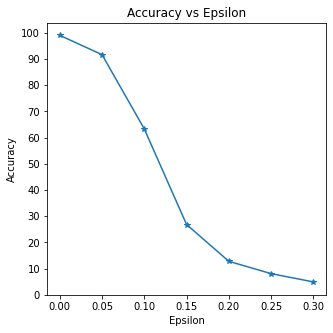

In [24]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 101, step=10))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

Plot several examples of adversarial samples for each epsilon.

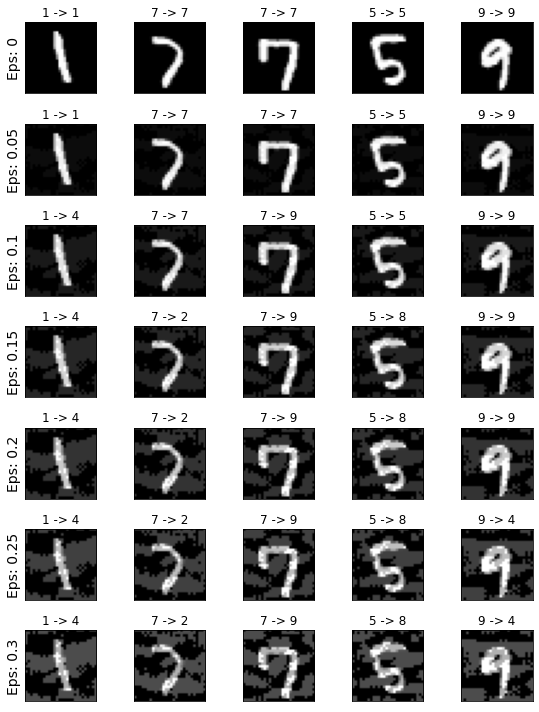

In [25]:
cnt = 0
plt.figure(figsize=(8,10))
for eps in epsilons:
    adv_examples = adversarials[eps]['adv_examples'][:5]
    init_preds = adversarials[eps]['init_preds'][:5]
    final_preds = adversarials[eps]['final_preds'][:5]

    for i in range(5):
        cnt += 1
        plt.subplot(len(epsilons), 5, cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if i == 0:
            plt.ylabel("Eps: {}".format(eps), fontsize=14)
        plt.title("{} -> {}".format(init_preds[i], final_preds[i]))
        plt.imshow(np.squeeze(adv_examples[i]), cmap="gray")
plt.tight_layout()
plt.show()

Create an adversarial dataset using epsilon = 0.25 that was also used in the [code from Papernot and McDaniel](https://github.com/tensorflow/cleverhans/blob/master/cleverhans/model_zoo/deep_k_nearest_neighbors/dknn.py).

In [26]:
adversarials = create_adversarials(model, testloader_adv, 0.25)

adv_data = torch.FloatTensor(adversarials['adv_examples'])
adv_targets = torch.LongTensor(adversarials['targets'])

advdataset = CustomTensorDataset(tensors=(adv_data, adv_targets), transform=None)
advloader = DataLoader(advdataset, batch_size=batch_size_test, shuffle=False, num_workers=2)

In [27]:
test_acc = test_final(model, advloader); test_acc


Test set: Avg. loss: 0.008444, Accuracy: 747/9250 (8.08%)



8.075675675675676

# Deep kNN

Now, let's implement DkNN. The code is based on the original [code from Papernot and McDaniel](https://github.com/tensorflow/cleverhans/blob/master/cleverhans/model_zoo/deep_k_nearest_neighbors/dknn.py). It was converted to PyTorch.

In [28]:
class NearestNeighbor:

    class BACKEND(enum.Enum):
        FALCONN = 1
        FAISS = 2

    def __init__(self, backend, dimension, neighbors, number_bits, nb_tables=None):
        assert backend in NearestNeighbor.BACKEND

        self._NEIGHBORS = neighbors
        self._BACKEND = backend

        if self._BACKEND is NearestNeighbor.BACKEND.FALCONN:
            self._init_falconn(dimension, number_bits, nb_tables)
        elif self._BACKEND is NearestNeighbor.BACKEND.FAISS:
            self._init_faiss(dimension)
        else:
            raise NotImplementedError

    def _init_falconn(self, dimension, number_bits, nb_tables):
        assert nb_tables >= self._NEIGHBORS

        # LSH parameters
        params_cp = falconn.LSHConstructionParameters()
        params_cp.dimension = dimension
        params_cp.lsh_family = falconn.LSHFamily.CrossPolytope
        params_cp.distance_function = falconn.DistanceFunction.EuclideanSquared
        params_cp.l = nb_tables
        params_cp.num_rotations = 2  # for dense set it to 1; for sparse data set it to 2
        params_cp.seed = 5721840
        params_cp.num_setup_threads = 0  # we want to use all the available threads to set up
        params_cp.storage_hash_table = falconn.StorageHashTable.BitPackedFlatHashTable

        # we build number_bits-bit hashes so that each table has
        # 2^number_bits bins; a rule of thumb is to have the number
        # of bins be the same order of magnitude as the number of data points
        falconn.compute_number_of_hash_functions(number_bits, params_cp)
        self._falconn_table = falconn.LSHIndex(params_cp)
        self._falconn_query_object = None
        self._FALCONN_NB_TABLES = nb_tables

    def _init_faiss(self, dimension):
        res = faiss.StandardGpuResources()
        self._faiss_index = faiss.GpuIndexFlatL2(res, dimension)

    def add(self, x):
        if self._BACKEND is NearestNeighbor.BACKEND.FALCONN:
            self._falconn_table.setup(x)
        elif self._BACKEND is NearestNeighbor.BACKEND.FAISS:
            self._faiss_index.add(x)
        else:
            raise NotImplementedError

    def find_knns(self, x, output):
        if self._BACKEND is NearestNeighbor.BACKEND.FALCONN:
            return self._find_knns_falconn(x, output)
        elif self._BACKEND is NearestNeighbor.BACKEND.FAISS:
            return self._find_knns_faiss(x, output)
        else:
            raise NotImplementedError

    def _find_knns_falconn(self, x, output):
        # Late falconn query_object construction
        # Since I suppose there might be an error
        # if table.setup() will be called after
        if self._falconn_query_object is None:
            self._falconn_query_object = self._falconn_table.construct_query_object()
            self._falconn_query_object.set_num_probes(self._FALCONN_NB_TABLES)

        missing_indices = np.zeros(output.shape, dtype=np.bool)

        for i in range(x.shape[0]):
            query_res = self._falconn_query_object.find_k_nearest_neighbors(x[i], self._NEIGHBORS)

            try:
                output[i, :] = query_res
            except:
                # mark missing indices
                missing_indices[i, len(query_res):] = True
                output[i, :len(query_res)] = query_res

        return missing_indices

    def _find_knns_faiss(self, x, output):
        neighbor_distance, neighbor_index = self._faiss_index.search(x, self._NEIGHBORS)

        missing_indices = neighbor_distance == -1
        d1 = neighbor_index.reshape(-1)

        output.reshape(-1)[np.logical_not(missing_indices.flatten())] = d1[np.logical_not(missing_indices.flatten())]

        return missing_indices


class DkNN:

    def __init__(self, model, nb_classes, neighbors, layers, trainloader, nearest_neighbor_backend, nb_tables=200, number_bits=17):
        """
        Implementation of the DkNN algorithm, see https://arxiv.org/abs/1803.04765 for more details
        :param model: model to be used
        :param nb_classes: the number of classes in the task
        :param neighbors: number of neighbors to find per layer
        :param layers: a list of layer names to include in the DkNN
        :param trainloader: data loader for the training data
        :param nearest_neighbor_backend: falconn or faiss to be used for LSH
        :param nb_tables: number of tables used by FALCONN to perform locality-sensitive hashing.
        :param number_bits: number of hash bits used by LSH.
        """
        print('---------- DkNN init')
        print()

        self.model = model
        self.nb_classes = nb_classes
        self.neighbors = neighbors
        self.layers = layers
        self.backend = nearest_neighbor_backend
        self.nb_tables = nb_tables
        self.number_bits = number_bits

        self.nb_cali = -1
        self.calibrated = False   

        # Compute training data activations
        activations = get_activations(trainloader, model, layers)
        self.train_activations = activations['activations']
        self.train_labels = activations['targets']

        # Build locality-sensitive hashing tables for training representations
        self.train_activations_lsh = copy.copy(self.train_activations)
        self.init_lsh()

    def init_lsh(self):
        """
        Initializes locality-sensitive hashing with FALCONN to find nearest neighbors in training data
        """
        self.query_objects = {} # contains the object that can be queried to find nearest neighbors at each layer
        self.centers = {} # mean of training data representation per layer (that needs to be substracted before NearestNeighbor)

        print("## Constructing the NearestNeighbor tables")

        for layer in self.layers:
            print("Constructing table for {}".format(layer))

            # Normalize all the lenghts, since we care about the cosine similarity
            self.train_activations_lsh[layer] /= np.linalg.norm(self.train_activations_lsh[layer], axis=1).reshape(-1, 1)

            # Center the dataset and the queries: this improves the performance of LSH quite a bit
            center = np.mean(self.train_activations_lsh[layer], axis=0)
            self.train_activations_lsh[layer] -= center
            self.centers[layer] = center

            # Constructing nearest neighbor table
            self.query_objects[layer] = NearestNeighbor(
                backend=self.backend,
                dimension=self.train_activations_lsh[layer].shape[1],
                number_bits=self.number_bits,
                neighbors=self.neighbors,
                nb_tables=self.nb_tables,
            )

            self.query_objects[layer].add(self.train_activations_lsh[layer])

        print("done!")
        print()


    def calibrate(self, calibloader):
        """
        Runs the DkNN on holdout data to calibrate the credibility metric
        :param calibloader: data loader for the calibration loader
        """
        print('---------- DkNN calibrate')
        print()

        # Compute calibration data activations
        self.nb_cali = len(calibloader.dataset)
        activations = get_activations(calibloader, self.model, self.layers)
        self.cali_activations = activations['activations']
        self.cali_labels = activations['targets']

        print("## Starting calibration of DkNN")

        cali_knns_ind, cali_knns_labels = self.find_train_knns(self.cali_activations)
        assert all([v.shape == (self.nb_cali, self.neighbors) for v in cali_knns_ind.values()])
        assert all([v.shape == (self.nb_cali, self.neighbors) for v in cali_knns_labels.values()])

        cali_knns_not_in_class = self.nonconformity(cali_knns_labels)
        cali_knns_not_in_l = np.zeros(self.nb_cali, dtype=np.int32)

        for i in range(self.nb_cali):
            cali_knns_not_in_l[i] = cali_knns_not_in_class[i, self.cali_labels[i]]

        cali_knns_not_in_l_sorted = np.sort(cali_knns_not_in_l)
        self.cali_nonconformity = np.trim_zeros(cali_knns_not_in_l_sorted, trim='f')
        self.nb_cali = self.cali_nonconformity.shape[0]
        self.calibrated = True

        print("DkNN calibration complete")

    def find_train_knns(self, data_activations):
        """
        Given a data_activation dictionary that contains a np array with activations for each layer,
        find the knns in the training data
        """
        knns_ind = {}
        knns_labels = {}

        for layer in self.layers:
            # Pre-process representations of data to normalize and remove training data mean
            data_activations_layer = copy.copy(data_activations[layer])
            nb_data = data_activations_layer.shape[0]
            data_activations_layer /= np.linalg.norm(data_activations_layer, axis=1).reshape(-1, 1)
            data_activations_layer -= self.centers[layer]

            # Use FALCONN to find indices of nearest neighbors in training data
            knns_ind[layer] = np.zeros((data_activations_layer.shape[0], self.neighbors), dtype=np.int32)
            knn_errors = 0

            knn_missing_indices = self.query_objects[layer].find_knns(data_activations_layer, knns_ind[layer])
            knn_errors += knn_missing_indices.flatten().sum()

            # Find labels of neighbors found in the training data
            knns_labels[layer] = np.zeros((nb_data, self.neighbors), dtype=np.int32)

            knns_labels[layer].reshape(-1)[
                np.logical_not(knn_missing_indices.flatten())
            ] = self.train_labels[
                knns_ind[layer].reshape(-1)[np.logical_not(knn_missing_indices.flatten())]                    
            ]

        return knns_ind, knns_labels

    def nonconformity(self, knns_labels):
        """
        Given an dictionary of nb_data x nb_classes dimension, compute the nonconformity of
        each candidate label for each data point: i.e. the number of knns whose label is
        different from the candidate label
        """
        nb_data = knns_labels[list(self.layers.keys())[0]].shape[0]
        knns_not_in_class = np.zeros((nb_data, self.nb_classes), dtype=np.int32)

        for i in range(nb_data):
            # Compute number of nearest neighbors per class
            knns_in_class = np.zeros((len(self.layers), self.nb_classes), dtype=np.int32)

            for layer_id, layer in enumerate(self.layers):
                knns_in_class[layer_id, :] = np.bincount(knns_labels[layer][i], minlength=self.nb_classes)

            # Compute number of knns in other class than class_id
            for class_id in range(self.nb_classes):
                knns_not_in_class[i, class_id] = np.sum(knns_in_class) - np.sum(knns_in_class[:, class_id])

        return knns_not_in_class

    def fprop(self, testloader):
        """
        Performs a forward pass through the DkNN on an numpy array of data
        """
        print('---------- DkNN predict')
        print()

        if not self.calibrated:
            raise ValueError("DkNN needs to be calibrated by calling DkNNModel.calibrate method once before inferring")

        # Compute test data activations
        activations = get_activations(testloader, self.model, self.layers)
        data_activations = activations['activations']
        
        start_time = time.time()
        _, knns_labels = self.find_train_knns(data_activations)
        end_time = time.time()
        
        print('kNN search time: {}'.format(end_time - start_time))

        # Calculate nonconformity
        knns_not_in_class = self.nonconformity(knns_labels)
        print('Nonconformity calculated')

        # Create predictions, confidence and credibility
        _, _, creds = self.preds_conf_cred(knns_not_in_class)
        print('Predictions created')

        return creds, activations['targets']

    def preds_conf_cred(self, knns_not_in_class):
        """
        Given an array of nb_data x nb_classes dimensions, use conformal prediction to compute
        the DkNN's prediction, confidence and credibility
        """
        nb_data = knns_not_in_class.shape[0]
        preds_knn = np.zeros(nb_data, dtype=np.int32)
        confs = np.zeros((nb_data, self.nb_classes), dtype=np.float32)
        creds = np.zeros((nb_data, self.nb_classes), dtype=np.float32)

        for i in range(nb_data):
            # p-value of test input for each class
            p_value = np.zeros(self.nb_classes, dtype=np.float32)

            for class_id in range(self.nb_classes):
                # p-value of (test point, candidate label)
                p_value[class_id] = (float(self.nb_cali) - bisect_left(self.cali_nonconformity, knns_not_in_class[i, class_id])) / float(self.nb_cali)

            preds_knn[i] = np.argmax(p_value)
            confs[i, preds_knn[i]] = 1. - np.sort(p_value)[-2]
            creds[i, preds_knn[i]] = p_value[preds_knn[i]]

        return preds_knn, confs, creds


def plot_reliability_diagram(confidence, labels):
    """
    Takes in confidence values (e.g. output of softmax or DkNN confidences) for
    predictions and correct labels for the data, plots a reliability diagram
    :param confidence: nb_samples x nb_classes with confidence scores
    :param labels: targets
    """
    assert len(confidence.shape) == 2
    assert len(labels.shape) == 1
    assert confidence.shape[0] == labels.shape[0]

    if confidence.max() <= 1.:
        # confidence array is output of softmax
        bins_start = [b / 10. for b in range(0, 10)]
        bins_end = [b / 10. for b in range(1, 11)]
        bins_center = [(b + .5) / 10. for b in range(0, 10)]
        preds_conf = np.max(confidence, axis=1)
        preds_l = np.argmax(confidence, axis=1)
    else:
        raise ValueError('Confidence values go above 1')

    print(preds_conf.shape, preds_l.shape)

    # Create var for reliability diagram (Will contain mean accuracies for each bin)
    reliability_diag = []
    num_points = []  # keeps the number of points in each bar

    # Find average accuracy per confidence bin
    for bin_start, bin_end in zip(bins_start, bins_end):
        above = preds_conf >= bin_start

        if bin_end == 1.:
            below = preds_conf <= bin_end
        else:
            below = preds_conf < bin_end

        mask = np.multiply(above, below)
        num_points.append(np.sum(mask))

        bin_mean_acc = max(0, np.mean(preds_l[mask] == labels[mask]))
        reliability_diag.append(bin_mean_acc)

    # Plot diagram
    assert len(reliability_diag) == len(bins_center)
    #print(reliability_diag)
    #print(bins_center)
    #print(num_points)

    fig, ax1 = plt.subplots()
    _ = ax1.bar(bins_center, reliability_diag, width=.1, alpha=0.8, edgecolor = "black")
    plt.xlim([0, 1.])
    ax1.set_ylim([0, 1.])

    ax2 = ax1.twinx()

    #print(sum(num_points))

    ax2.plot(bins_center, num_points, color='r', linestyle='-', linewidth=7.0)
    ax2.set_ylabel('Number of points in the data', fontsize=16, color='r')

    if len(np.argwhere(confidence[0] != 0.)) == 1:
        # This is a DkNN diagram
        ax1.set_xlabel('Prediction Credibility', fontsize=16)
    else:
        # This is a softmax diagram
        ax1.set_xlabel('Prediction Confidence', fontsize=16)

    ax1.set_ylabel('Prediction Accuracy', fontsize=16)
    ax1.tick_params(axis='both', labelsize=14)
    ax2.tick_params(axis='both', labelsize=14, colors='r')
    fig.tight_layout()
    plt.show()

Let's create a dataloader for training data that should be used to initialize the DkNN (shuffle must be false!). Then, initialize the DkNN.

In [29]:
# Create training data loader for DkNN
trainloader_dknn = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size_train, shuffle=False, num_workers=2
)

# Initialize DkNN
nb_classes_mnist = 10
dknn = DkNN(model, nb_classes_mnist, neighbors, layers, trainloader_dknn, NearestNeighbor.BACKEND.FALCONN)

---------- DkNN init

## Fetching Activations from Layer relu1
Processing Batch 0
Processing Batch 1
Processing Batch 2
Processing Batch 3
Processing Batch 4
Processing Batch 5
Processing Batch 6
Processing Batch 7
Processing Batch 8
Processing Batch 9
Processing Batch 10
Processing Batch 11
Processing Batch 12
Processing Batch 13
Processing Batch 14
Processing Batch 15
Processing Batch 16
Processing Batch 17
Processing Batch 18
Processing Batch 19
Processing Batch 20
Processing Batch 21
Processing Batch 22
Processing Batch 23
Processing Batch 24
Processing Batch 25
Processing Batch 26
Processing Batch 27
Processing Batch 28
Processing Batch 29
Processing Batch 30
Processing Batch 31
Processing Batch 32
Processing Batch 33
Processing Batch 34
Processing Batch 35
Processing Batch 36
Processing Batch 37
Processing Batch 38
Processing Batch 39
Processing Batch 40
Processing Batch 41
Processing Batch 42
Processing Batch 43
Processing Batch 44
Processing Batch 45
Processing Batch 46
Process

Processing Batch 39
Processing Batch 40
Processing Batch 41
Processing Batch 42
Processing Batch 43
Processing Batch 44
Processing Batch 45
Processing Batch 46
Processing Batch 47
Processing Batch 48
Processing Batch 49
Processing Batch 50
Processing Batch 51
Processing Batch 52
Processing Batch 53
Processing Batch 54
Processing Batch 55
Processing Batch 56
Processing Batch 57
Processing Batch 58
Processing Batch 59
Processing Batch 60
Processing Batch 61
Processing Batch 62
Processing Batch 63
Processing Batch 64
Processing Batch 65
Processing Batch 66
Processing Batch 67
Processing Batch 68
Processing Batch 69
Processing Batch 70
Processing Batch 71
Processing Batch 72
Processing Batch 73
Processing Batch 74
Processing Batch 75
Processing Batch 76
Processing Batch 77
Processing Batch 78
Processing Batch 79
Processing Batch 80
Processing Batch 81
Processing Batch 82
Processing Batch 83
Processing Batch 84
Processing Batch 85
Processing Batch 86
Processing Batch 87
Processing Batch 88


Then, calibrate.

In [30]:
dknn.calibrate(calibloader)

---------- DkNN calibrate

## Fetching Activations from Layer relu1
Processing Batch 0
done!

## Fetching Activations from Layer relu2
Processing Batch 0
done!

## Fetching Activations from Layer relu3
Processing Batch 0
done!

## Fetching Activations from Layer fc
Processing Batch 0
done!

## Starting calibration of DkNN
DkNN calibration complete


Create DkNN predictions for the test set.

In [31]:
start_test_time = time.time()
dknn_preds_testset, test_targets = dknn.fprop(testloader)
end_test_time = time.time()

print()
print('---------------------------------------------')
print('preds:   {}'.format(dknn_preds_testset.shape))
print('targets: {}'.format(test_targets.shape))

---------- DkNN predict

## Fetching Activations from Layer relu1
Processing Batch 0
Processing Batch 1
Processing Batch 2
Processing Batch 3
Processing Batch 4
Processing Batch 5
Processing Batch 6
Processing Batch 7
Processing Batch 8
Processing Batch 9
done!

## Fetching Activations from Layer relu2
Processing Batch 0
Processing Batch 1
Processing Batch 2
Processing Batch 3
Processing Batch 4
Processing Batch 5
Processing Batch 6
Processing Batch 7
Processing Batch 8
Processing Batch 9
done!

## Fetching Activations from Layer relu3
Processing Batch 0
Processing Batch 1
Processing Batch 2
Processing Batch 3
Processing Batch 4
Processing Batch 5
Processing Batch 6
Processing Batch 7
Processing Batch 8
Processing Batch 9
done!

## Fetching Activations from Layer fc
Processing Batch 0
Processing Batch 1
Processing Batch 2
Processing Batch 3
Processing Batch 4
Processing Batch 5
Processing Batch 6
Processing Batch 7
Processing Batch 8
Processing Batch 9
done!

kNN search time: 284.09638

In [32]:
print('time: {}'.format(end_test_time - start_test_time))

time: 295.53004717826843


Let's plot the result. `plot-reliability_diagram` produces a warning regarding taking a mean of an empty list. According to the discussion on [here](https://stackoverflow.com/questions/29688168/mean-nanmean-and-warning-mean-of-empty-slice) we probably can ignore that warning.

(9250,) (9250,)


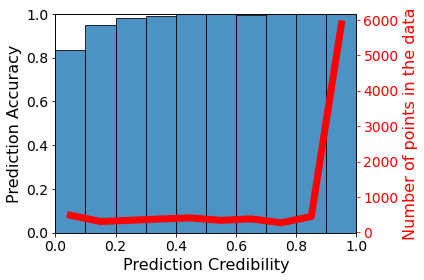

In [33]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    plot_reliability_diagram(dknn_preds_testset, test_targets)

Create DkNN predictions for the adversarial set.

In [34]:
start_test_time = time.time()
dknn_preds_advset, adv_targets = dknn.fprop(advloader)
end_test_time = time.time()

print()
print('---------------------------------------------')
print('preds:   {}'.format(dknn_preds_advset.shape))
print('targets: {}'.format(test_targets.shape))

---------- DkNN predict

## Fetching Activations from Layer relu1
Processing Batch 0
Processing Batch 1
Processing Batch 2
Processing Batch 3
Processing Batch 4
Processing Batch 5
Processing Batch 6
Processing Batch 7
Processing Batch 8
Processing Batch 9
done!

## Fetching Activations from Layer relu2
Processing Batch 0
Processing Batch 1
Processing Batch 2
Processing Batch 3
Processing Batch 4
Processing Batch 5
Processing Batch 6
Processing Batch 7
Processing Batch 8
Processing Batch 9
done!

## Fetching Activations from Layer relu3
Processing Batch 0
Processing Batch 1
Processing Batch 2
Processing Batch 3
Processing Batch 4
Processing Batch 5
Processing Batch 6
Processing Batch 7
Processing Batch 8
Processing Batch 9
done!

## Fetching Activations from Layer fc
Processing Batch 0
Processing Batch 1
Processing Batch 2
Processing Batch 3
Processing Batch 4
Processing Batch 5
Processing Batch 6
Processing Batch 7
Processing Batch 8
Processing Batch 9
done!

kNN search time: 243.09886

In [35]:
print('time: {}'.format(end_test_time - start_test_time))

time: 254.82392191886902


Let's plot the result.

(9250,) (9250,)


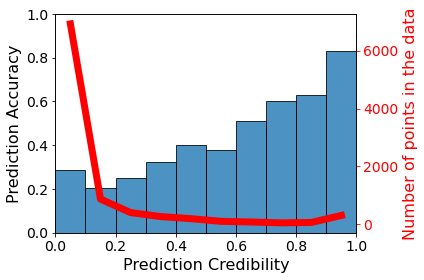

In [36]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    plot_reliability_diagram(dknn_preds_advset, test_targets)

For comparision let us also create the plot using the softmax scores instead of the DkNN scores.

In [37]:
def get_softmax_scores(model, dataloader):
    model.eval()
    softmax_scores = []
    
    with torch.no_grad():
        for data in dataloader:
            # Get the inputs; data is a list of [inputs, labels]
            inputs, targets = data

            if use_cuda:
              inputs, targets = inputs.cuda(), targets.cuda()
            
            # Forward + loss + correct
            outputs = model(inputs)
            criterion(outputs, targets)
            
            # Get softmax scores
            softmax_output = torch.nn.functional.softmax(outputs.data, dim=1)
            pred, pred_idx = torch.max(softmax_output, 1)
            softmax_score = np.zeros((pred.shape[0],10), dtype=np.float32)

            pred = pred.detach().cpu().numpy()
            pred_idx = pred_idx.detach().cpu().numpy()

            softmax_score[np.arange(pred_idx.shape[0]), pred_idx] = pred
            softmax_scores.append(softmax_score)
    
    return np.vstack(softmax_scores)

Compute the softmax scores for the test set.

In [38]:
softmax_scores_testset = get_softmax_scores(model, testloader); softmax_scores_testset.shape

(9250, 10)

Let's plot the result.

(9250,) (9250,)


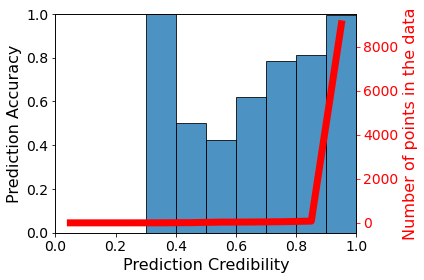

In [39]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    plot_reliability_diagram(softmax_scores_testset, test_targets)

Compute the softmax scores for the test set.

In [40]:
softmax_scores_advset = get_softmax_scores(model, advloader); softmax_scores_advset.shape

(9250, 10)

(9250,) (9250,)


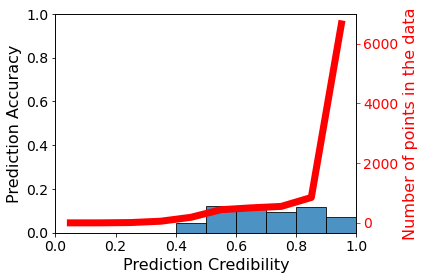

In [41]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    plot_reliability_diagram(softmax_scores_advset, adv_targets)